# üíª Notebook de Compara√ß√£o de Pipelines de Machine Learning (Diabetes)

## Objetivo

O objetivo final deste projeto √© prever se um paciente possui ou n√£o diabetes com base em alguns dados m√©dicos.

Confeccionamos **dois pipelines distintos de Machine Learning** durante os estudos para entrega do Tech Challenge. Neste notebook, procuraremos explicar a linha de racioc√≠nio que fundamentou as escolhas de cada um dos pipelines e, por fim, concluirmos de forma objetiva qual foi o mais assertivo.

### Estrutura da Compara√ß√£o dos pipelines:

**Pipeline A (Baseline - MLOps):**
- Abordagem conservadora com preserva√ß√£o m√°xima dos dados
- Foco em robustez e estabilidade
- Utiliza t√©cnicas cl√°ssicas de pr√©-processamento

**Pipeline B (Otimizado - Deep Dive):**
- Abordagem otimizada com feature engineering avan√ßada
- Foco em maximizar sensibilidade (Recall)
- Incorpora t√©cnicas modernas e ajustes de threshold

### Perguntas a Responder:

1. Qual pipeline oferece melhor capacidade de detec√ß√£o de diabetes (Recall)?
2. O ganho de performance justifica a complexidade adicional?
3. Quais features s√£o mais importantes para o diagn√≥stico?
4. Como diferentes estrat√©gias de pr√©-processamento impactam os resultados?

Ao final, teremos evid√™ncias quantitativas para determinar a **abordagem mais eficaz** para este problema de sa√∫de p√∫blica.

## 1. Configura√ß√£o e Fun√ß√µes Comuns

### 1.1 Instala√ß√£o e Importa√ß√£o de Bibliotecas

Nesta se√ß√£o, importamos todas as bibliotecas necess√°rias para ambos os pipelines, garantindo um ambiente consistente para a execu√ß√£o e compara√ß√£o dos modelos.

**Bibliotecas Principais:**
- **pandas/numpy:** Manipula√ß√£o e an√°lise de dados
- **scikit-learn:** Algoritmos de ML, pr√©-processamento e m√©tricas
- **imblearn:** T√©cnicas de balanceamento (SMOTE)
- **xgboost:** Algoritmo de gradient boosting avan√ßado
- **seaborn/matplotlib:** Visualiza√ß√£o de dados
- **shap:** Interpretabilidade de modelos (an√°lise SHAP values)
- **kagglehub:** Download autom√°tico do dataset

In [1]:
# C√©lula 1.1: Instala√ß√£o (descomente se necess√°rio)
# !pip install pandas numpy scikit-learn matplotlib seaborn imblearn xgboost kagglehub shap

# C√©lula 1.1: Importa√ß√µes
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import kagglehub
import shap
import xgboost as xgb

# Scikit-learn e Imblearn
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import recall_score, f1_score, precision_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# Configura√ß√£o para evitar warnings do SHAP
shap.initjs()

print("Todas as bibliotecas e ferramentas foram importadas.")

Todas as bibliotecas e ferramentas foram importadas.


### 1.2 Fun√ß√µes Auxiliares Comuns

Fun√ß√µes compartilhadas por ambos os pipelines para garantir consist√™ncia na obten√ß√£o e tradu√ß√£o dos dados.

**Fun√ß√µes inclu√≠das:**
- `traduzir_colunas()`: Traduz nomes das colunas para portugu√™s, facilitando a interpreta√ß√£o
- `carregar_e_salvar_kaggle()`: Baixa o dataset diretamente do Kaggle e salva localmente

**Por que centralizar estas fun√ß√µes?**
- Garante que ambos os pipelines usem exatamente os mesmos dados de entrada
- Facilita manuten√ß√£o e reduz duplica√ß√£o de c√≥digo
- Permite compara√ß√£o justa entre as abordagens

In [2]:
# C√©lula 1.2: Fun√ß√µes Auxiliares Comuns

DATASET_HANDLE = 'mathchi/diabetes-data-set'
TARGET_COL = 'Outcome'
DATA_PATH_TEMP = 'temp_data_file.csv' # Nome tempor√°rio do arquivo CSV ap√≥s download

def traduzir_colunas(dados: pd.DataFrame) -> pd.DataFrame:
    '''Traduz os nomes das colunas.'''
    return dados.rename(columns={
        'Pregnancies': 'Gesta√ß√µes',
        'Glucose': 'Glicose',
        'BloodPressure': 'Press√£o',
        'SkinThickness': 'Espessura da pele',
        'Insulin': 'Insulina',
        'BMI': 'IMC',
        'DiabetesPedigreeFunction': 'Hereditariedade',
        'Age': 'Idade',
        'Outcome': 'Diagn√≥stico'
    })

def carregar_e_salvar_kaggle(handle: str, save_path: str) -> pd.DataFrame:
    '''Carrega o dataset do KaggleHub, salva o CSV localmente e retorna o DataFrame.'''
    print(f'Iniciando o carregamento dos dados de: {handle}')
    
    # Baixar e obter o caminho do arquivo
    endereco_de_origem = kagglehub.dataset_download(handle=handle, force_download=True)
    diretorio_de_origem = Path(endereco_de_origem).resolve()
    
    # Encontrar e carregar o CSV
    lista_dados_csv = []
    for item in diretorio_de_origem.iterdir():
        if item.is_file() and item.suffix.lower() == '.csv':
            df = pd.read_csv(item)
            lista_dados_csv.append(df)
            # Salvar em um local conhecido para o Pipeline B usar (se necess√°rio)
            df.to_csv(save_path, index=False)
            print(f"Arquivo CSV salvo temporariamente em '{save_path}'")
            
    if not lista_dados_csv:
        raise FileNotFoundError("Nenhum arquivo CSV encontrado no dataset do Kaggle.")
        
    dados = pd.concat(lista_dados_csv, axis=0, ignore_index=True)
    print('Finalizando o carregamento dos dados\n')
    return dados

# Carregar o dataset para que ambos os pipelines possam utiliz√°-lo
dados_originais = carregar_e_salvar_kaggle(DATASET_HANDLE, DATA_PATH_TEMP)
print(f"Shape dos dados carregados: {dados_originais.shape}")

Iniciando o carregamento dos dados de: mathchi/diabetes-data-set


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 8.91k/8.91k [00:00<00:00, 960kB/s]

Extracting files...
Arquivo CSV salvo temporariamente em 'temp_data_file.csv'
Finalizando o carregamento dos dados

Shape dos dados carregados: (768, 9)


### 1.3 An√°lise explorat√≥ria dos Dados

// ...existing code...

<VSCode.Cell id="#VSC-c2a3297c" language="markdown">
### 1.3 An√°lise Explorat√≥ria dos Dados

Antes de iniciar os pipelines de machine learning, √© fundamental compreender profundamente os dados com os quais estamos trabalhando. Esta an√°lise explorat√≥ria nos permite:

**Objetivos da An√°lise:**
1. **Entender a estrutura** do dataset (dimens√µes, tipos de dados, valores ausentes)
2. **Identificar padr√µes** nas distribui√ß√µes das vari√°veis
3. **Detectar outliers** e valores biologicamente imposs√≠veis
4. **Analisar correla√ß√µes** entre features e o diagn√≥stico de diabetes
5. **Validar decis√µes de pr√©-processamento** que ser√£o tomadas nos pipelines

**Por que esta etapa √© importante?**
- Decis√µes de pr√©-processamento (como remo√ß√£o de colunas ou tratamento de zeros) devem ser baseadas em evid√™ncias
- Compreender a distribui√ß√£o dos dados ajuda na escolha de m√©todos de imputa√ß√£o
- Correla√ß√µes revelam quais features podem ser mais relevantes para o modelo


AN√ÅLISE EXPLORAT√ìRIA DO DATASET DE DIABETES

1. ESTRUTURA E INFORMA√á√ïES GERAIS

Dimens√µes do dataset: 768 registros √ó 9 colunas

Primeiras 5 linhas do dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

----------------------------------------------------------------------
Informa√ß√µes sobre tipos de dados e mem√≥ria:
------------------

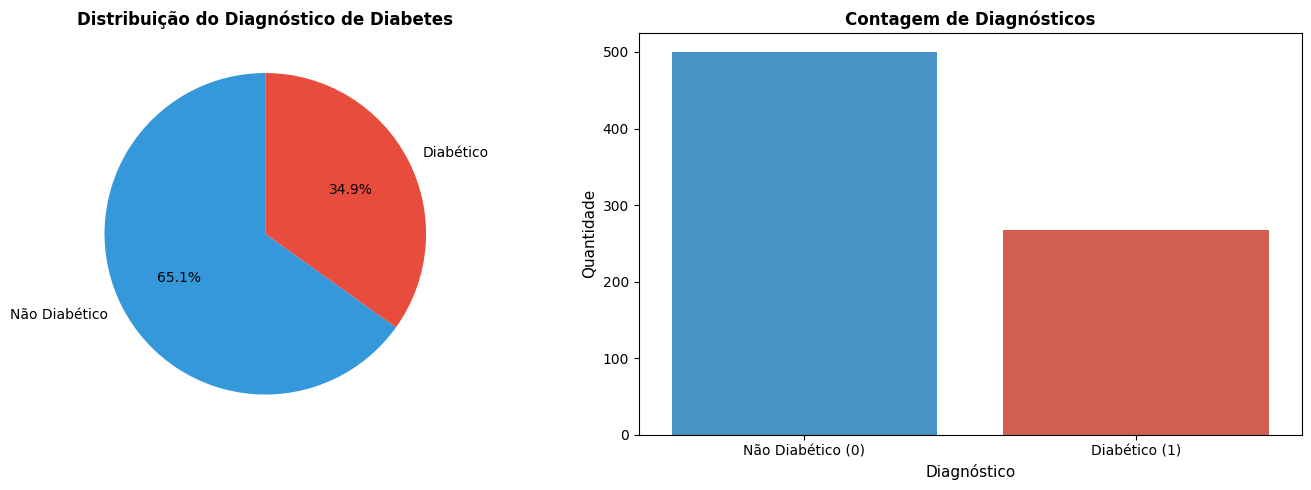


üìä OBSERVA√á√ÉO:
Dataset DESBALANCEADO: 65.1% n√£o-diab√©ticos vs 34.9% diab√©ticos
‚Üí Justifica o uso de SMOTE nos pipelines para balanceamento!

4. DISTRIBUI√á√ÉO DAS VARI√ÅVEIS NUM√âRICAS


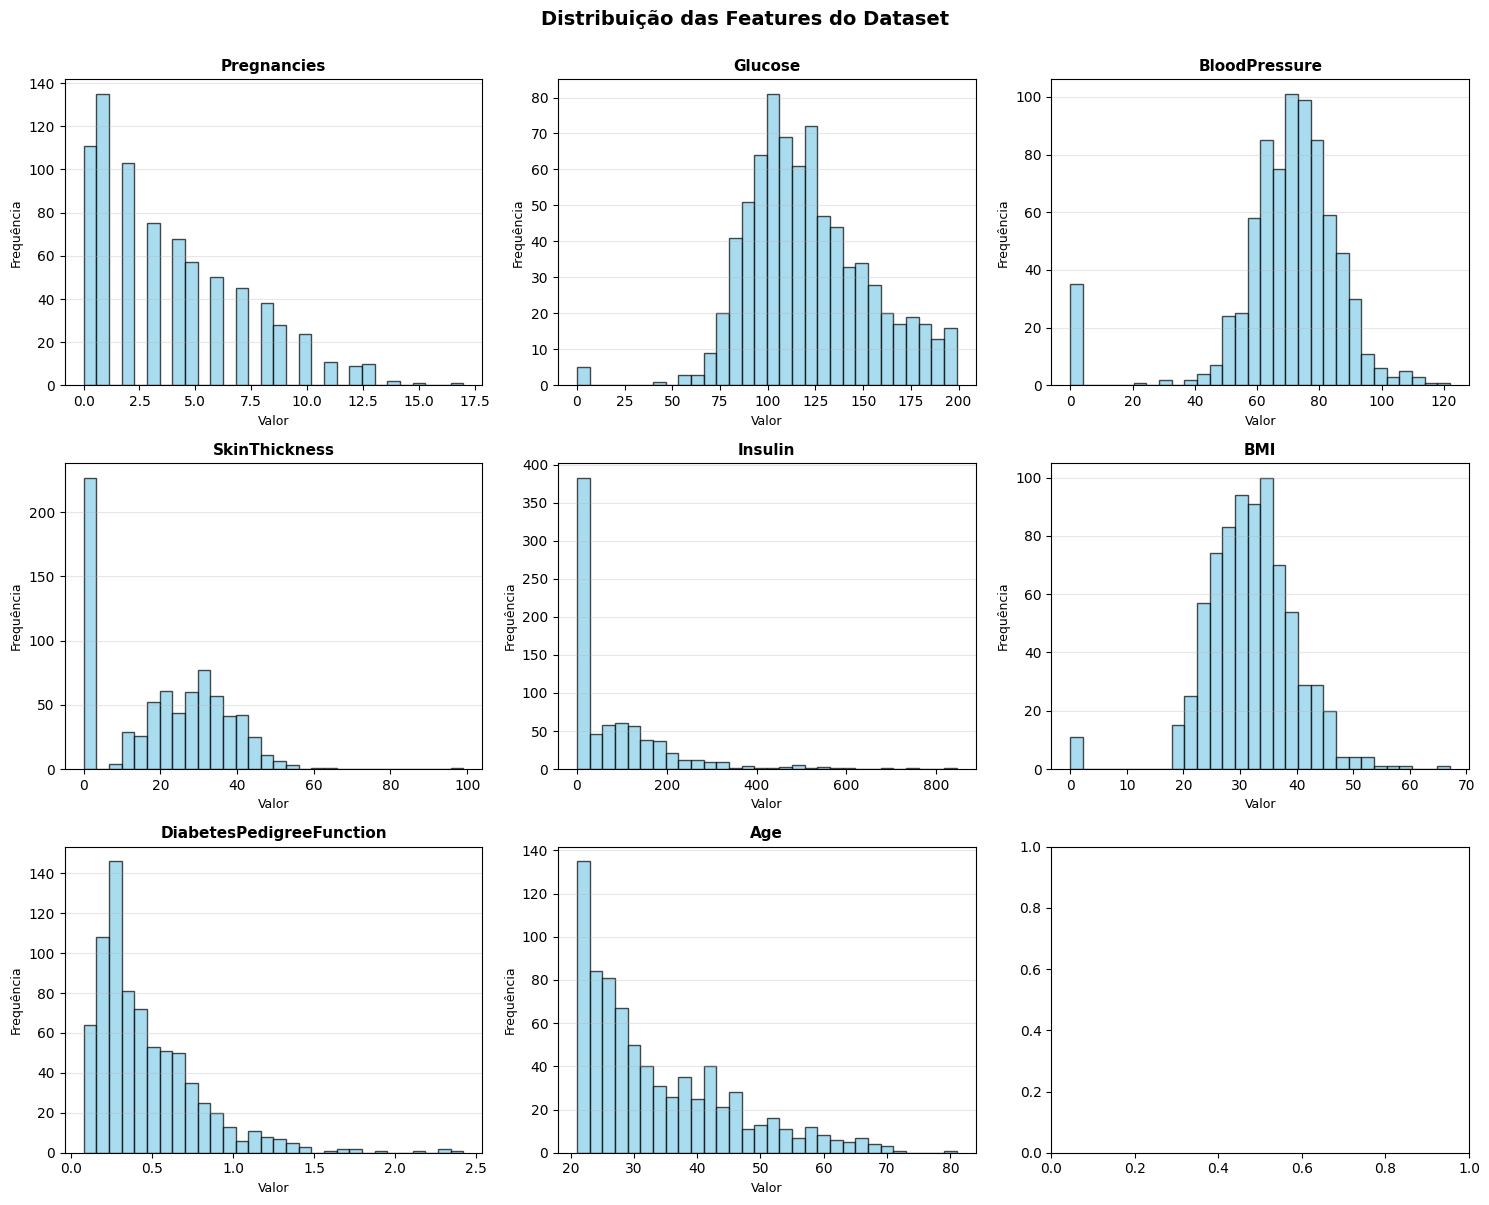


5. AN√ÅLISE DE OUTLIERS (BOXPLOTS)


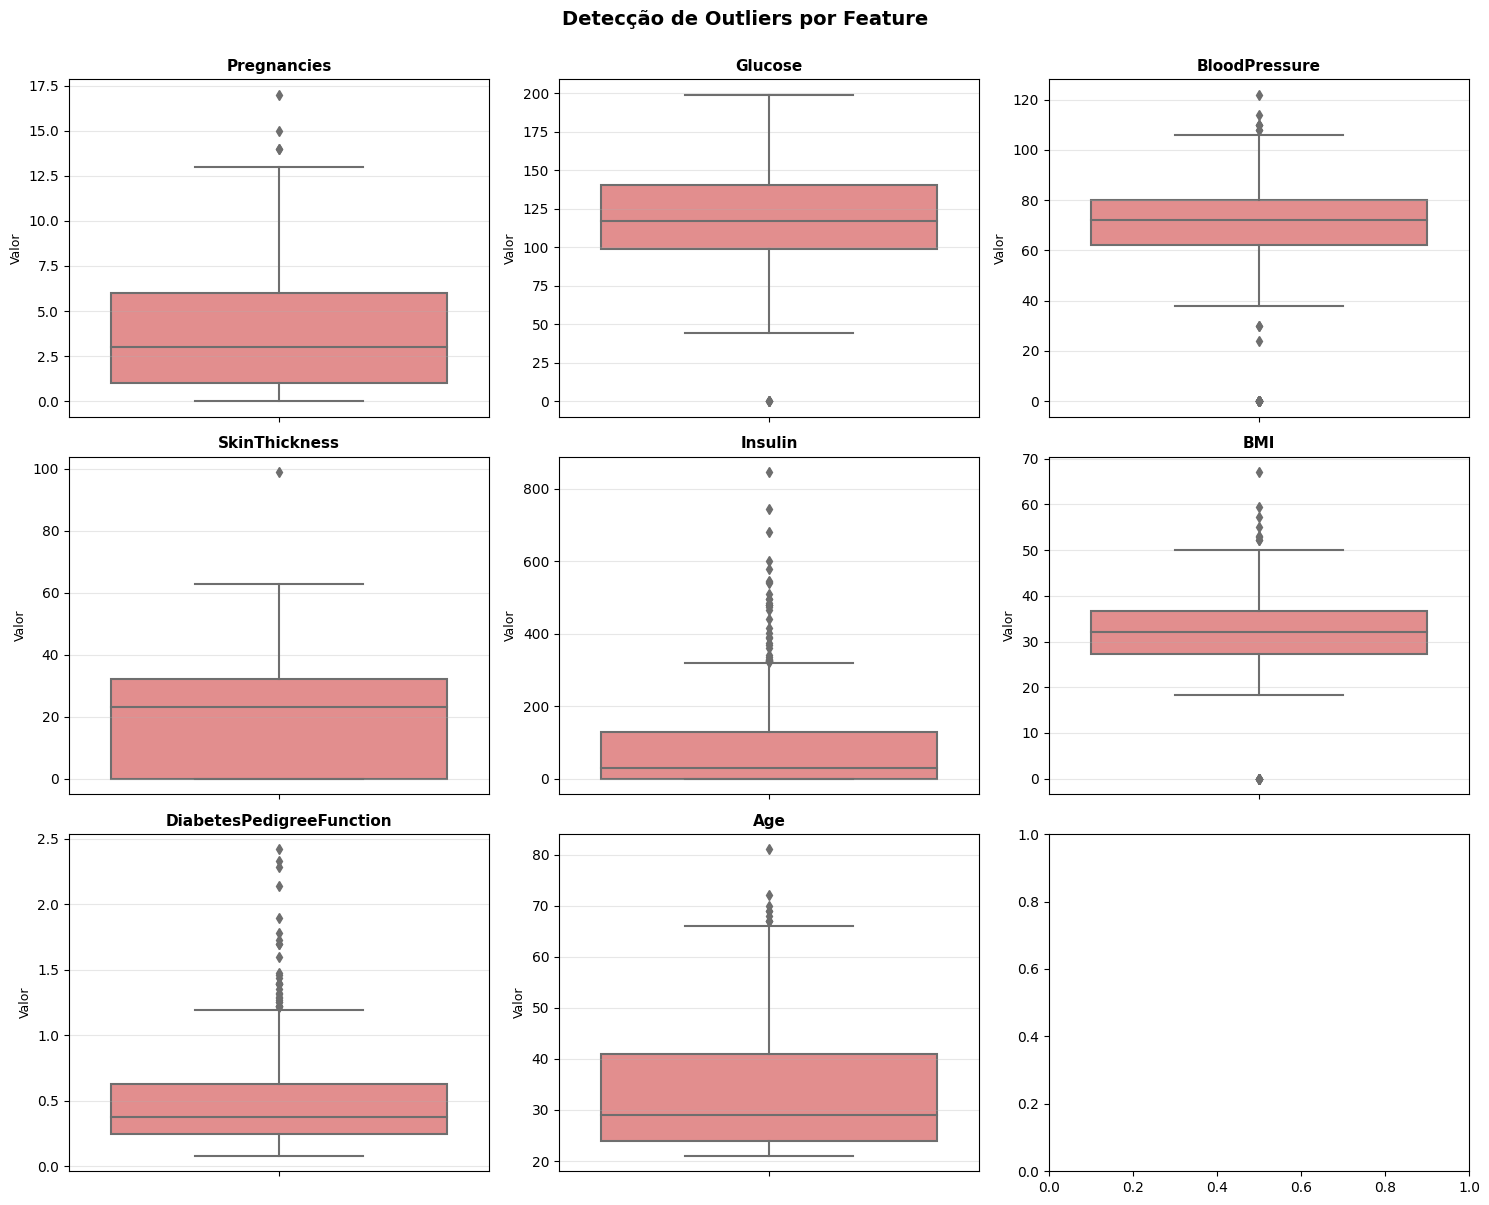


üìå OBSERVA√á√ÉO:
- Outliers s√£o comuns em dados m√©dicos e podem ser casos leg√≠timos (ex: diabetes severo)
- Por isso, escolhemos RobustScaler (resistente a outliers) ao inv√©s de StandardScaler

6. CORRELA√á√ÉO ENTRE FEATURES E DIAGN√ìSTICO


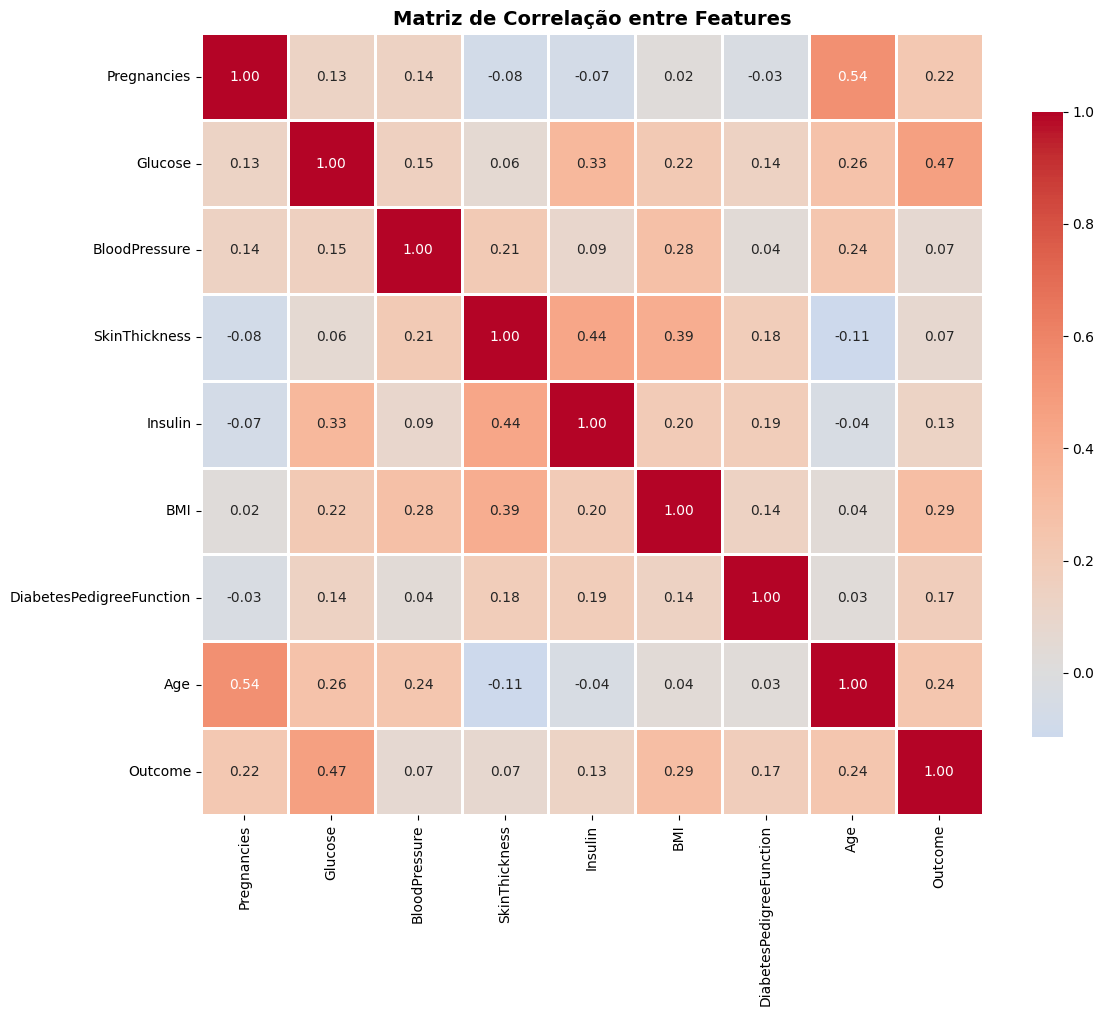


----------------------------------------------------------------------
Ranking de Correla√ß√£o com o Diagn√≥stico (Outcome):
----------------------------------------------------------------------
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068

üîç PRINCIPAIS INSIGHTS:
1. Glucose (0.467): Maior correla√ß√£o - predictor mais forte!
2. BMI (0.293): Segunda maior correla√ß√£o
3. Age (0.238): Idade √© fator importante


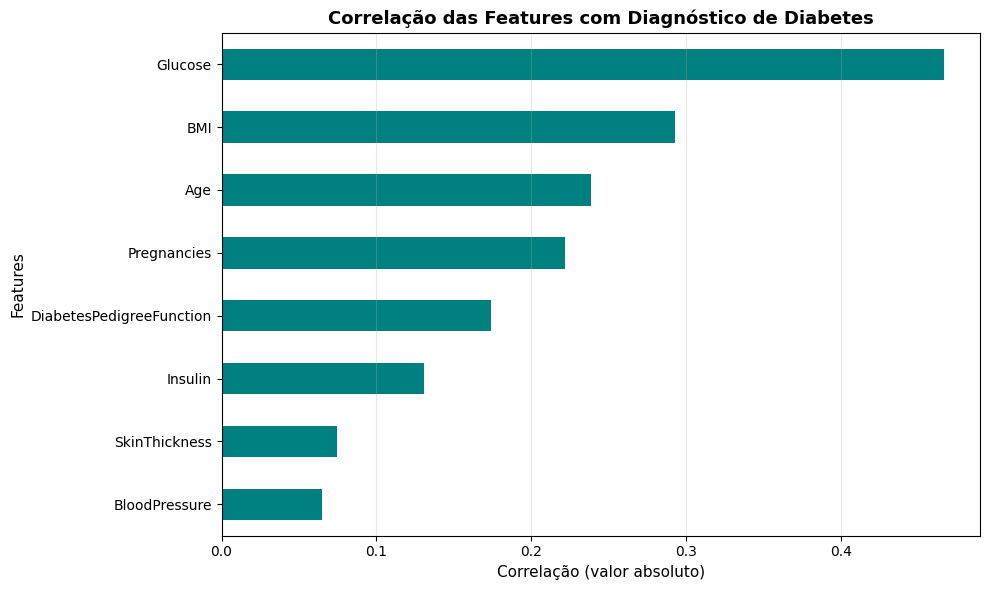


7. AN√ÅLISE BIVARIADA: FEATURES VS DIAGN√ìSTICO

8. RESUMO DA AN√ÅLISE EXPLORAT√ìRIA

‚úÖ PRINCIPAIS DESCOBERTAS:

1. QUALIDADE DOS DADOS:
   - N√£o h√° valores NaN expl√≠citos
   - Zeros inv√°lidos presentes em v√°rias colunas:
     ‚Ä¢ Insulin: 48.7% zeros (ALTA taxa - candidata √† remo√ß√£o)
     ‚Ä¢ SkinThickness: 29.6% zeros (ALTA taxa - candidata √† remo√ß√£o)
     ‚Ä¢ BloodPressure: 4.5% zeros (trat√°vel por imputa√ß√£o)
     ‚Ä¢ BMI: 1.4% zeros (trat√°vel por imputa√ß√£o)
     ‚Ä¢ Glucose: 0.6% zeros (trat√°vel por imputa√ß√£o)

2. DESBALANCEAMENTO:
   - Classes desbalanceadas: 65.1% vs 34.9%
   - Necess√°rio: SMOTE para balanceamento

3. CORRELA√á√ïES:
   - Glucose: Maior preditor (r = 0.467)
   - BMI: Segundo preditor (r = 0.293)
   - Age: Terceiro preditor (r = 0.238)

4. OUTLIERS:
   - Presentes em v√°rias features (ex: Insulin, Glucose)
   - S√£o casos m√©dicos leg√≠timos, n√£o erros
   - Justifica uso de RobustScaler (resistente a outliers)

üìã DECIS√ïES DE PR√â-PROCES

In [3]:
# C√©lula 1.3: An√°lise Explorat√≥ria dos Dados

print("=" * 70)
print("AN√ÅLISE EXPLORAT√ìRIA DO DATASET DE DIABETES")
print("=" * 70)

# ============================================================================
# 1. INFORMA√á√ïES GERAIS DO DATASET
# ============================================================================
print("\n" + "=" * 70)
print("1. ESTRUTURA E INFORMA√á√ïES GERAIS")
print("=" * 70)

print(f"\nDimens√µes do dataset: {dados_originais.shape[0]} registros √ó {dados_originais.shape[1]} colunas")
print("\nPrimeiras 5 linhas do dataset:")
print(dados_originais.head())

print("\n" + "-" * 70)
print("Informa√ß√µes sobre tipos de dados e mem√≥ria:")
print("-" * 70)
dados_originais.info()

print("\n" + "-" * 70)
print("Estat√≠sticas descritivas:")
print("-" * 70)
print(dados_originais.describe().round(2))

# ============================================================================
# 2. AN√ÅLISE DE VALORES AUSENTES E ZEROS INV√ÅLIDOS
# ============================================================================
print("\n" + "=" * 70)
print("2. VALORES AUSENTES E ZEROS BIOLOGICAMENTE IMPOSS√çVEIS")
print("=" * 70)

# Verificar NaNs expl√≠citos
print("\nValores NaN expl√≠citos por coluna:")
nan_counts = dados_originais.isnull().sum()
print(nan_counts)

# Analisar zeros que s√£o biologicamente imposs√≠veis
print("\n" + "-" * 70)
print("An√°lise de ZEROS (potencialmente inv√°lidos):")
print("-" * 70)

colunas_com_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
zeros_analysis = pd.DataFrame({
    'Coluna': colunas_com_zeros,
    'Zeros': [dados_originais[col].eq(0).sum() for col in colunas_com_zeros],
    'Percentual (%)': [(dados_originais[col].eq(0).sum() / len(dados_originais) * 100).round(2) 
                       for col in colunas_com_zeros]
})
print(zeros_analysis.to_string(index=False))

print("\n‚ö†Ô∏è INTERPRETA√á√ÉO:")
print("- Glucose = 0: Biologicamente IMPOSS√çVEL (5 casos)")
print("- BloodPressure = 0: Biologicamente IMPOSS√çVEL (35 casos)")
print("- SkinThickness = 0: Provavelmente inv√°lido (227 casos = 29.6%)")
print("- Insulin = 0: Provavelmente inv√°lido (374 casos = 48.7%)")
print("- BMI = 0: Biologicamente IMPOSS√çVEL (11 casos)")

# ============================================================================
# 3. DISTRIBUI√á√ÉO DA VARI√ÅVEL ALVO (OUTCOME)
# ============================================================================
print("\n" + "=" * 70)
print("3. DISTRIBUI√á√ÉO DO DIAGN√ìSTICO (VARI√ÅVEL ALVO)")
print("=" * 70)

outcome_counts = dados_originais['Outcome'].value_counts()
outcome_pct = dados_originais['Outcome'].value_counts(normalize=True) * 100

print(f"\nDistribui√ß√£o de classes:")
print(f"- N√£o Diab√©tico (0): {outcome_counts[0]} casos ({outcome_pct[0]:.2f}%)")
print(f"- Diab√©tico (1): {outcome_counts[1]} casos ({outcome_pct[1]:.2f}%)")

# Gr√°fico de pizza da distribui√ß√£o do diagn√≥stico
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pizza chart
axes[0].pie(outcome_counts, labels=['N√£o Diab√©tico', 'Diab√©tico'], 
           autopct='%1.1f%%', startangle=90, colors=['#3498db', '#e74c3c'])
axes[0].set_title('Distribui√ß√£o do Diagn√≥stico de Diabetes', fontsize=12, fontweight='bold')

# Bar chart
sns.countplot(x='Outcome', data=dados_originais, palette=['#3498db', '#e74c3c'], ax=axes[1])
axes[1].set_xlabel('Diagn√≥stico', fontsize=11)
axes[1].set_ylabel('Quantidade', fontsize=11)
axes[1].set_title('Contagem de Diagn√≥sticos', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(['N√£o Diab√©tico (0)', 'Diab√©tico (1)'])

plt.tight_layout()
plt.show()

print("\nüìä OBSERVA√á√ÉO:")
print(f"Dataset DESBALANCEADO: {outcome_pct[0]:.1f}% n√£o-diab√©ticos vs {outcome_pct[1]:.1f}% diab√©ticos")
print("‚Üí Justifica o uso de SMOTE nos pipelines para balanceamento!")

# ============================================================================
# 4. DISTRIBUI√á√ÉO DAS FEATURES NUM√âRICAS
# ============================================================================
print("\n" + "=" * 70)
print("4. DISTRIBUI√á√ÉO DAS VARI√ÅVEIS NUM√âRICAS")
print("=" * 70)

# Histogramas de todas as features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(dados_originais.columns[:-1]):  # Exclui Outcome
    axes[idx].hist(dados_originais[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Valor', fontsize=9)
    axes[idx].set_ylabel('Frequ√™ncia', fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Distribui√ß√£o das Features do Dataset', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============================================================================
# 5. BOXPLOTS PARA IDENTIFICA√á√ÉO DE OUTLIERS
# ============================================================================
print("\n" + "=" * 70)
print("5. AN√ÅLISE DE OUTLIERS (BOXPLOTS)")
print("=" * 70)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(dados_originais.columns[:-1]):
    sns.boxplot(y=dados_originais[col], color='lightcoral', ax=axes[idx])
    axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Valor', fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Detec√ß√£o de Outliers por Feature', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nüìå OBSERVA√á√ÉO:")
print("- Outliers s√£o comuns em dados m√©dicos e podem ser casos leg√≠timos (ex: diabetes severo)")
print("- Por isso, escolhemos RobustScaler (resistente a outliers) ao inv√©s de StandardScaler")

# ============================================================================
# 6. MATRIZ DE CORRELA√á√ÉO
# ============================================================================
print("\n" + "=" * 70)
print("6. CORRELA√á√ÉO ENTRE FEATURES E DIAGN√ìSTICO")
print("=" * 70)

# Calcular matriz de correla√ß√£o
corr_matrix = dados_originais.corr()

# Heatmap da matriz de correla√ß√£o
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correla√ß√£o entre Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Ranking de correla√ß√£o com Outcome
print("\n" + "-" * 70)
print("Ranking de Correla√ß√£o com o Diagn√≥stico (Outcome):")
print("-" * 70)

correlacao_outcome = corr_matrix['Outcome'].drop('Outcome').abs().sort_values(ascending=False)
print(correlacao_outcome.to_string())

print("\nüîç PRINCIPAIS INSIGHTS:")
print(f"1. Glucose ({correlacao_outcome.iloc[0]:.3f}): Maior correla√ß√£o - predictor mais forte!")
print(f"2. BMI ({correlacao_outcome.iloc[1]:.3f}): Segunda maior correla√ß√£o")
print(f"3. Age ({correlacao_outcome.iloc[2]:.3f}): Idade √© fator importante")

# Visualizar correla√ß√£o espec√≠fica com Outcome
plt.figure(figsize=(10, 6))
correlacao_outcome.sort_values().plot(kind='barh', color='teal')
plt.title('Correla√ß√£o das Features com Diagn√≥stico de Diabetes', fontsize=13, fontweight='bold')
plt.xlabel('Correla√ß√£o (valor absoluto)', fontsize=11)
plt.ylabel('Features', fontsize=11)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================================
# 7. AN√ÅLISE BIVARIADA: FEATURES VS OUTCOME
# ============================================================================
print("\n" + "=" * 70)
print("7. AN√ÅLISE BIVARIADA: FEATURES VS DIAGN√ìSTICO")
print("=" * 70)

# ============================================================================
# 8. RESUMO E CONCLUS√ïES DA EDA
# ============================================================================
print("\n" + "=" * 70)
print("8. RESUMO DA AN√ÅLISE EXPLORAT√ìRIA")
print("=" * 70)

print("\n‚úÖ PRINCIPAIS DESCOBERTAS:")
print("\n1. QUALIDADE DOS DADOS:")
print("   - N√£o h√° valores NaN expl√≠citos")
print("   - Zeros inv√°lidos presentes em v√°rias colunas:")
print("     ‚Ä¢ Insulin: 48.7% zeros (ALTA taxa - candidata √† remo√ß√£o)")
print("     ‚Ä¢ SkinThickness: 29.6% zeros (ALTA taxa - candidata √† remo√ß√£o)")
print("     ‚Ä¢ BloodPressure: 4.5% zeros (trat√°vel por imputa√ß√£o)")
print("     ‚Ä¢ BMI: 1.4% zeros (trat√°vel por imputa√ß√£o)")
print("     ‚Ä¢ Glucose: 0.6% zeros (trat√°vel por imputa√ß√£o)")

print("\n2. DESBALANCEAMENTO:")
print(f"   - Classes desbalanceadas: {outcome_pct[0]:.1f}% vs {outcome_pct[1]:.1f}%")
print("   - Necess√°rio: SMOTE para balanceamento")

print("\n3. CORRELA√á√ïES:")
print(f"   - Glucose: Maior preditor (r = {corr_matrix.loc['Glucose', 'Outcome']:.3f})")
print(f"   - BMI: Segundo preditor (r = {corr_matrix.loc['BMI', 'Outcome']:.3f})")
print(f"   - Age: Terceiro preditor (r = {corr_matrix.loc['Age', 'Outcome']:.3f})")

print("\n4. OUTLIERS:")
print("   - Presentes em v√°rias features (ex: Insulin, Glucose)")
print("   - S√£o casos m√©dicos leg√≠timos, n√£o erros")
print("   - Justifica uso de RobustScaler (resistente a outliers)")

print("\nüìã DECIS√ïES DE PR√â-PROCESSAMENTO VALIDADAS:")
print("   ‚úì Pipeline A: Imputar zeros com KNN (preserva todas as features)")
print("   ‚úì Pipeline B: Remover Insulin e SkinThickness (>30% ausentes)")
print("   ‚úì Ambos: Usar RobustScaler (outliers leg√≠timos)")
print("   ‚úì Ambos: Aplicar SMOTE (desbalanceamento)")

print("\n" + "=" * 70)
print("FIM DA AN√ÅLISE EXPLORAT√ìRIA")
print("=" * 70 + "\n")

## 2. Execu√ß√£o do Pipeline A (Modelo MLOps - Baseline)

Este pipeline representa uma abordagem **robusta e conservadora** de pr√©-processamento, priorizando a integridade dos dados e a diversidade de modelos.

### Caracter√≠sticas Principais do Pipeline A:

**1. Estrat√©gia de Imputa√ß√£o:**
- Utiliza **KNN Imputer (k=5)** para tratar valores ausentes
- **Por qu√™?** Este m√©todo considera a similaridade entre registros, preservando padr√µes locais nos dados
- Valores faltantes s√£o estimados com base nos 5 vizinhos mais pr√≥ximos.

**2. Normaliza√ß√£o:**
- Aplica **RobustScaler** para padroniza√ß√£o
- **Por qu√™?** Este m√©todo √© resistente a outliers, usando mediana e IQR (Intervalo Interquartil)
- Em dados m√©dicos, outliers podem ser casos leg√≠timos (ex: diabetes severo), n√£o erros a serem descartados

**3. Balanceamento:**
- Usa **SMOTE** (Synthetic Minority Over-sampling Technique)
- **Por qu√™?** O dataset possui desbalanceamento entre casos diab√©ticos e n√£o-diab√©ticos
- SMOTE cria exemplos sint√©ticos da classe minorit√°ria, melhorando a capacidade do modelo de detectar diabetes

**4. Conjunto de Modelos:**
- Logistic Regression, Decision Tree, KNeighbors e Random Forest
- **Por qu√™?** Diversidade de algoritmos permite comparar diferentes abordagens: linear, baseada em √°rvores, e baseada em dist√¢ncia
- Todos configurados com `class_weight='balanced'` para lidar com o desbalanceamento

**5. Crit√©rio de Avalia√ß√£o:**
- Foco em **Recall (Sensibilidade)**
- **Por qu√™?** No diagn√≥stico m√©dico, √© mais cr√≠tico **n√£o perder casos positivos** (evitar falsos negativos)
- Preferimos identificar todos os poss√≠veis diab√©ticos, mesmo que isso gere alguns falsos alarmes

### 2.1 Fun√ß√µes Exclusivas do Pipeline A

In [4]:
# C√©lula 2.1: Fun√ß√µes Exclusivas do Pipeline A

def separar_A(dados: pd.DataFrame, target: str):
    '''Separa features e alvo, e divide em treino e teste (80/20 estratificado).'''
    X_dados = dados.drop(columns=[target], axis=1)
    y_dados = dados[target]
    return train_test_split(X_dados, y_dados, test_size=0.2, random_state=42, stratify=y_dados)

def imputar_A(X_treino: pd.DataFrame, X_teste: pd.DataFrame):
    '''Substitui zeros inv√°lidos por NaN e usa KNNImputer (k=5).'''
    print('Iniciando a imputa√ß√£o dos dados (KNN)')
    colunas_invalidas = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']
    X_treino[colunas_invalidas] = X_treino[colunas_invalidas].replace(0, np.nan)
    X_teste[colunas_invalidas] = X_teste[colunas_invalidas].replace(0, np.nan)
    imputer = KNNImputer(n_neighbors=5)
    
    # Usando .copy() para garantir que a transforma√ß√£o n√£o afete o DataFrame original global
    X_treino_imputado = pd.DataFrame(imputer.fit_transform(X_treino), columns=X_treino.columns, index=X_treino.index)
    X_teste_imputado = pd.DataFrame(imputer.transform(X_teste), columns=X_teste.columns, index=X_teste.index)
    
    print('Finalizando a imputa√ß√£o dos dados\n')
    return X_treino_imputado, X_teste_imputado

def balancear_A(X_treino: pd.DataFrame, y_treino: pd.DataFrame):
    '''Equilibra a quantidade de dados por diagn√≥stico usando SMOTE.'''
    print('Iniciando o balanceamento dos dados (SMOTE)')
    X_treino_balanceado, y_treino_balanceado = SMOTE(random_state=42).fit_resample(X_treino, y_treino)
    print(f'Finalizando o balanceamento dos dados. Novos positivos: {y_treino_balanceado.sum()}\n')
    return X_treino_balanceado, y_treino_balanceado

def padronizar_A(X_treino: pd.DataFrame, X_teste: pd.DataFrame):
    '''Aplica padroniza√ß√£o nas colunas usando RobustScaler.'''
    print('Iniciando o escalonamento dos dados (RobustScaler)')
    scaler = RobustScaler()
    X_treino_padronizado = pd.DataFrame(scaler.fit_transform(X_treino), columns=X_treino.columns, index=X_treino.index)
    X_teste_padronizado = pd.DataFrame(scaler.transform(X_teste), columns=X_teste.columns, index=X_teste.index)
    print('Finalizando o escalonamento dos dados\n')
    return X_treino_padronizado, X_teste_padronizado

def criar_modelos_A():
    '''Gera uma lista de inst√¢ncias de modelos para avalia√ß√£o.'''
    return {
        'Logistic Regression (A)': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
        'Decision Tree (A)': DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=4, min_samples_split=10, min_samples_leaf=5, random_state=42),
        'KNeighbors (A)': KNeighborsClassifier(n_neighbors=5, weights='distance'),
        'Random Forest (A)': RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42)
    }

def avaliar_A(modelos, X_teste, y_teste):
    '''Avalia modelos e retorna o de melhor Recall, coletando os resultados.'''
    print('Iniciando a avalia√ß√£o dos modelos do Pipeline A')
    resultados = []
    
    for nome, modelo in modelos.items():
        y_previsto = modelo.predict(X_teste)
        
        resultados.append({
            'Pipeline': 'A',
            'Modelo': nome,
            'Precision': precision_score(y_teste, y_previsto, zero_division=0),
            'Recall': recall_score(y_teste, y_previsto, zero_division=0),
            'F1-score': f1_score(y_teste, y_previsto, zero_division=0),
        })
        print(f'\n--- Classifica√ß√£o do modelo {nome} ---')
        print(classification_report(y_teste, y_previsto, zero_division=0))

    df_resultados = pd.DataFrame(resultados)
    
    melhor_modelo_df = df_resultados.loc[df_resultados['Recall'].idxmax()]
    nome_melhor_modelo = melhor_modelo_df['Modelo']
    melhor_modelo = modelos[nome_melhor_modelo]
    
    print(f'\nMelhor modelo (baseado em Recall): {nome_melhor_modelo}')
    return melhor_modelo, df_resultados

def treinar_A(modelos, X_treino, y_treino):
    '''Treina uma lista de modelos.'''
    print('Iniciando o treino dos modelos do Pipeline A')
    for modelo in modelos.values():
        modelo.fit(X_treino, y_treino)
    print('Finalizando o treino dos modelos\n')
    return modelos

### 2.2 Execu√ß√£o do Fluxo A

Nesta c√©lula, executamos o **pipeline completo do modelo baseline**, seguindo a sequ√™ncia:

1. **Separa√ß√£o treino/teste** (80/20) com estratifica√ß√£o para manter propor√ß√£o de classes
2. **Imputa√ß√£o** usando KNN (k=5) para preencher valores ausentes
3. **Balanceamento** com SMOTE para equilibrar classes
4. **Padroniza√ß√£o** com RobustScaler (resistente a outliers)
5. **Treinamento** de m√∫ltiplos modelos (LogReg, DT, RF, KNN)
6. **Avalia√ß√£o** focada em Recall (sensibilidade)

**Resultado esperado:**
M√©tricas de desempenho de todos os modelos e identifica√ß√£o do melhor modelo baseado em Recall.

In [5]:
# C√©lula 2.2: Fluxo Principal do Pipeline A

print('=============================================')
print('=== EXECUTANDO O PIPELINE A (BASELINE) ===')
print('=============================================\n')

dados_A = dados_originais.copy()

# 1. Separar Treino/Teste
X_treino_A, X_teste_A, y_treino_A, y_teste_A = separar_A(dados_A, TARGET_COL)

# 2. Imputa√ß√£o (KNN Imputer)
X_treino_imputado_A, X_teste_imputado_A = imputar_A(X_treino_A.copy(), X_teste_A.copy())

# 3. Balanceamento (SMOTE)
X_treino_base_A, y_treino_base_A = balancear_A(X_treino_imputado_A, y_treino_A)

# 4. Padroniza√ß√£o (RobustScaler)
X_treino_padronizado_A, X_teste_padronizado_A = padronizar_A(X_treino_base_A, X_teste_imputado_A)
feat_names_A = X_treino_padronizado_A.columns.tolist()

# 5. Modelagem e Treinamento
modelos_A = criar_modelos_A()
modelos_treinados_A = treinar_A(modelos_A, X_treino_padronizado_A, y_treino_base_A)

# 6. Avalia√ß√£o e Coleta de Resultados
melhor_modelo_A, resultados_A = avaliar_A(modelos_treinados_A, X_teste_padronizado_A, y_teste_A)

print('\n=============================================')
print(f'RESULTADOS FINAIS DO PIPELINE A COLETADOS.')
print('=============================================\n')

=== EXECUTANDO O PIPELINE A (BASELINE) ===

Iniciando a imputa√ß√£o dos dados (KNN)
Finalizando a imputa√ß√£o dos dados

Iniciando o balanceamento dos dados (SMOTE)
Finalizando o balanceamento dos dados. Novos positivos: 400

Iniciando o escalonamento dos dados (RobustScaler)
Finalizando o escalonamento dos dados

Iniciando o treino dos modelos do Pipeline A
Finalizando o treino dos modelos

Iniciando a avalia√ß√£o dos modelos do Pipeline A

--- Classifica√ß√£o do modelo Logistic Regression (A) ---
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       100
           1       0.61      0.72      0.66        54

    accuracy                           0.74       154
   macro avg       0.72      0.74      0.73       154
weighted avg       0.75      0.74      0.74       154


--- Classifica√ß√£o do modelo Decision Tree (A) ---
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       100
       

## 3. Execu√ß√£o do Pipeline B (Otimizado/Deep Dive)

Este pipeline representa uma abordagem **otimizada e focada**, com pr√©-processamento mais agressivo e t√©cnicas avan√ßadas de modelagem.

### Caracter√≠sticas Principais do Pipeline B:

**1. Limpeza de Features:**
- **Remove colunas problem√°ticas:** SkinThickness (30% ausentes) e Insulin (48% ausentes)
- **Por qu√™?** Quando mais de 40% dos dados est√£o ausentes, imputar se torna "inventar" mais dados do que observar
- Decis√£o baseada no princ√≠pio: **qualidade sobre quantidade** - melhor ter menos features confi√°veis

**2. Estrat√©gia de Imputa√ß√£o:**
- Utiliza **SimpleImputer com mediana** (n√£o KNN)
- **Por qu√™?** Mais simples e eficiente, apropriado quando h√° poucas colunas a imputar
- Ap√≥s remover as colunas problem√°ticas, apenas ~6% dos dados precisam ser imputados

**3. Feature Engineering:**
- **Cria vari√°veis derivadas** que capturam intera√ß√µes e padr√µes de risco:
  - `idade_maior_45`: Flag bin√°rio (Age ‚â• 45), pois risco de diabetes aumenta com idade
  - `imc_obeso`: Flag bin√°rio (BMI ‚â• 30), obesidade √© fator de risco conhecido
  - `idade_bmi`: Intera√ß√£o (Age √ó BMI), captura risco combinado
  - `glucose_bmi`: Intera√ß√£o (Glucose √ó BMI), relaciona metabolismo com composi√ß√£o corporal

**Por qu√™ criar estas vari√°veis?**
- Modelos de ML podem ter dificuldade em capturar rela√ß√µes n√£o-lineares automaticamente
- Feature Engineering **explicita** rela√ß√µes que sabemos serem importantes do dom√≠nio m√©dico
- Exemplo: Uma pessoa de 50 anos com BMI 35 tem risco MAIOR que a soma isolada das partes

**4. Modelos Adicionais:**
- Inclui **XGBoost** al√©m dos modelos cl√°ssicos
- **Por qu√™?** XGBoost √© bem visto pela comunidade para dados tabulares, frequentemente superando outros algoritmos
- Lida bem com intera√ß√µes complexas entre features

**5. Threshold Ajustado:**
- Usa **threshold de 0.3** (ao inv√©s do padr√£o 0.5) para classifica√ß√£o
- **Por qu√™?** Threshold mais baixo significa que o modelo classifica como "diab√©tico" com menos certeza
- **Consequ√™ncia:** Aumenta Recall (captura mais casos positivos), mas pode reduzir Precision
- **Justificativa m√©dica:** Preferimos encaminhar mais pacientes para exames adicionais do que perder um caso real

### Compara√ß√£o Pipeline A vs B:

| Aspecto | Pipeline A (Baseline) | Pipeline B (Otimizado) |
|---------|----------------------|------------------------|
| **Filosofia** | Preservar dados originais | Otimizar features |
| **Imputa√ß√£o** | KNN (complexa) | Mediana (simples) |
| **Colunas** | Todas (9) | Reduzidas (7) + 4 novas |
| **Threshold** | 0.5 (padr√£o) | 0.3 (ajustado) |
| **Foco** | Robustez | Performance (Recall) |

### Estrat√©gia do Pipeline B

Este pipeline adota uma filosofia diferente: **otimiza√ß√£o agressiva** baseada em conhecimento do dom√≠nio m√©dico.

**Principais diferen√ßas em rela√ß√£o ao Pipeline A:**

1. **Remo√ß√£o de dados ruidosos** ao inv√©s de imputa√ß√£o complexa
2. **Cria√ß√£o expl√≠cita de intera√ß√µes** entre vari√°veis (feature engineering)
3. **Threshold customizado** (0.3) para priorizar detec√ß√£o sobre precis√£o
4. **Inclus√£o de XGBoost** - algoritmo mais moderno e poderoso

**Hip√≥tese a testar:**
Menos dados de melhor qualidade + features derivadas + threshold otimizado = **maior sensibilidade diagn√≥stica**

### 3.1 Fun√ß√µes Exclusivas do Pipeline B

In [6]:
# C√©lula 3.1: Fun√ß√µes Exclusivas do Pipeline B

def split_and_oversample(X, y, test_size=0.2, random_state=42, stratify=True, smote_random_state=42):
    """
    Faz split dos dados em treino/teste e aplica SMOTE apenas nos dados de treino.

    Par√¢metros:
        X (array ou DataFrame): Features j√° processadas/escaladas.
        y (array ou Series): Labels/vari√°vel alvo.
        test_size (float): Propor√ß√£o de teste.
        random_state (int): Semente para reprodutibilidade.
        stratify (bool): Se True, faz stratify em y.
        smote_random_state (int): Semente do SMOTE.

    Retorna:
        X_train_res, X_test, y_train_res, y_test
    """
    strat = y if stratify else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=strat
    )

    smote = SMOTE(random_state=smote_random_state)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    return X_train_res, X_test, y_train_res, y_test

def preprocess_diabetes_data_B(df: pd.DataFrame):
    """
    Pr√©-processamento:
    - Remove SkinThickness e Insulin
    - Trata zeros em Glucose, BloodPressure, BMI (converte para NaN e imputa mediana)
    - Feature engineering: cria vari√°veis de risco
    """
    df = df.copy() 
    
    # 1. Remove colunas
    df = df.drop(['SkinThickness', 'Insulin'], axis=1)
    
    # 2. Trata zeros biologicamente imposs√≠veis (SimpleImputer Mediana)
    cols_to_treat = ['Glucose', 'BloodPressure', 'BMI']
    for col in cols_to_treat:
        df[col] = df[col].replace(0, np.nan)
        
    imputer = SimpleImputer(strategy='median')
    df[cols_to_treat] = imputer.fit_transform(df[cols_to_treat])

    # 3. FEATURE ENGINEERING: Vari√°veis de risco
    df['idade_maior_45'] = (df['Age'] >= 45).astype(int)
    df['imc_obeso'] = (df['BMI'] >= 30).astype(int)
    df['idade_bmi'] = df['Age'] * df['BMI']
    df['glucose_bmi'] = df['Glucose'] * df['BMI']

    # 4. Separa features e target
    X = df.drop('Outcome', axis=1)
    y = df['Outcome'].values
    feat_names = X.columns.tolist()

    # 5. Scaling (RobustScaler - Ajustado para o fluxo do notebook)
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled_df = pd.DataFrame(X_scaled, columns=feat_names, index=X.index)
    
    return X_scaled_df, y, feat_names

def get_models():
    """
    Cria e retorna dicion√°rio com modelos de classifica√ß√£o configurados para melhor recall.
    """    
    return {
        'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=42),
        'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
        'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss', random_state=42)
    }

def train_models(models, X_train, y_train):
    for model in models.values():
        model.fit(X_train, y_train)
    return models

def evaluate_models(models, X_test, y_test, feat_names, threshold=0.3):
    """
    Avalia m√∫ltiplos modelos de classifica√ß√£o, exibe m√©tricas e matriz de confus√£o,
    e retorna o modelo com o melhor Recall.
    """
    best_recall = -1
    best_f1 = -1
    best_model_name = None
    best_model = None
    results = []

    for name, model in models.items():

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = (y_proba >= threshold).astype(int)
        else:
            y_pred = model.predict(X_test)
            
        current_recall = recall_score(y_test, y_pred)
        current_f1 = f1_score(y_test, y_pred)
        current_precision = precision_score(y_test, y_pred, zero_division=0)

        results.append({
            'Pipeline': 'B',
            'Modelo': name,
            'Precision': current_precision,
            'Recall': current_recall,
            'F1-score': current_f1,
        })
        
        # L√≥gica de rastreamento do melhor modelo (Baseado no Recall)
        if current_recall > best_recall:
            best_recall = current_recall
            best_f1 = current_f1 
            best_model_name = name
            best_model = model

        print(f"\n--- {name} ---")
        print(f"Recall (Sensibilidade): {current_recall:.2f}")
        print(f"F1-score: {current_f1:.2f}")
        print("\nRelat√≥rio de classifica√ß√£o detalhado:")
        print(classification_report(y_test, y_pred))
        print("Matriz de Confus√£o (linhas = real, colunas = predito):")
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Matriz de Confus√£o - {name} (Threshold={threshold})')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.show()

    print("==================================================")
    print(f"üèÜ Melhor Modelo Encontrado ({best_model_name})")
    print(f"   Crit√©rio de Sele√ß√£o: Maior Recall")
    print(f"   Recall (Sensibilidade): {best_recall:.2f}")
    print(f"   F1-score: {best_f1:.2f}")
    print("==================================================")

    df_results = pd.DataFrame(results)
    
    return best_model, df_results, best_model_name

### 3.2 Execu√ß√£o do Fluxo B

Nesta c√©lula, executamos o **pipeline otimizado**, seguindo a sequ√™ncia:

1. **Pr√©-processamento avan√ßado:**
   - Remo√ß√£o de colunas problem√°ticas (SkinThickness, Insulin)
   - Imputa√ß√£o simples com mediana
   - Feature engineering (cria√ß√£o de 4 novas vari√°veis)
   
2. **Split e balanceamento** (80/20) com SMOTE

3. **Treinamento** de m√∫ltiplos modelos, incluindo XGBoost

4. **Avalia√ß√£o** com threshold ajustado (0.3) para aumentar sensibilidade

**Diferencial do Pipeline B:**
- Menos features (7 originais) + 4 features derivadas
- Threshold personalizado para maximizar detec√ß√£o de casos positivos
- Modelo XGBoost para capturar intera√ß√µes complexas

**Resultado esperado:**
M√©tricas otimizadas com foco em maximizar Recall, mesmo que isso implique em redu√ß√£o de Precision.

=== EXECUTANDO O PIPELINE B (OTIMIZADO/DEEP DIVE) ===



[11:52:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

X does not have valid feature names, but LogisticRegression was fitted with feature names



--- Logistic Regression ---
Recall (Sensibilidade): 0.85
F1-score: 0.63

Relat√≥rio de classifica√ß√£o detalhado:
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       100
           1       0.51      0.85      0.63        54

    accuracy                           0.66       154
   macro avg       0.69      0.70      0.65       154
weighted avg       0.74      0.66      0.66       154

Matriz de Confus√£o (linhas = real, colunas = predito):


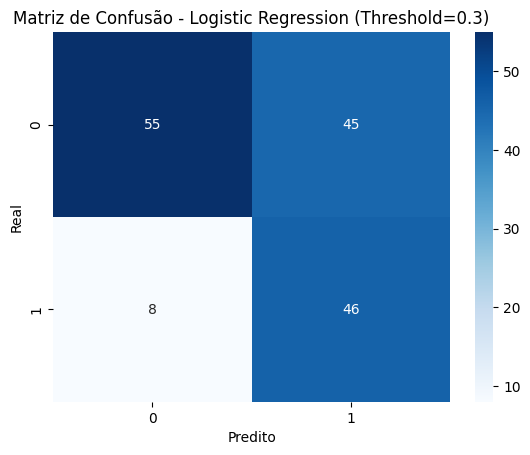


--- Decision Tree ---
Recall (Sensibilidade): 0.56
F1-score: 0.56

Relat√≥rio de classifica√ß√£o detalhado:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       100
           1       0.56      0.56      0.56        54

    accuracy                           0.69       154
   macro avg       0.66      0.66      0.66       154
weighted avg       0.69      0.69      0.69       154

Matriz de Confus√£o (linhas = real, colunas = predito):


X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


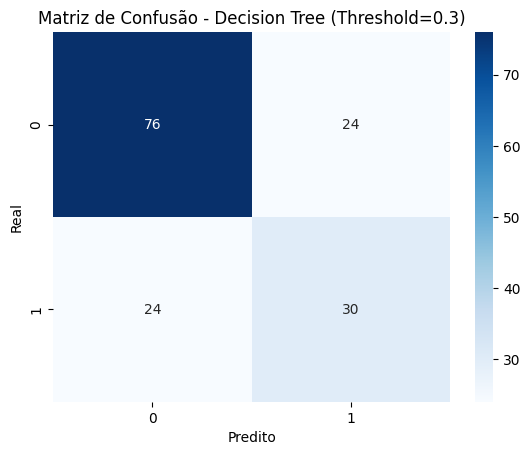


--- Random Forest ---
Recall (Sensibilidade): 0.91
F1-score: 0.72

Relat√≥rio de classifica√ß√£o detalhado:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77       100
           1       0.59      0.91      0.72        54

    accuracy                           0.75       154
   macro avg       0.76      0.78      0.74       154
weighted avg       0.81      0.75      0.75       154

Matriz de Confus√£o (linhas = real, colunas = predito):


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


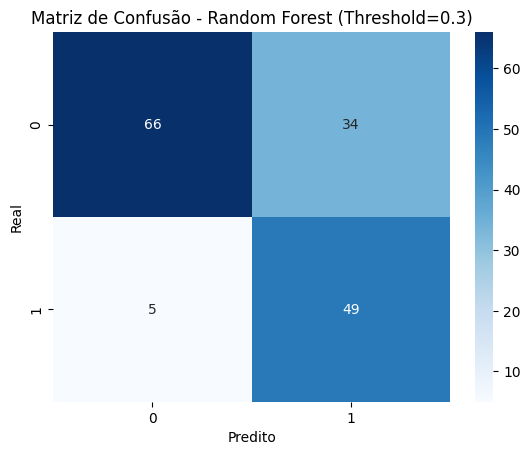


--- XGBoost ---
Recall (Sensibilidade): 0.76
F1-score: 0.67

Relat√≥rio de classifica√ß√£o detalhado:
              precision    recall  f1-score   support

           0       0.85      0.73      0.78       100
           1       0.60      0.76      0.67        54

    accuracy                           0.74       154
   macro avg       0.73      0.74      0.73       154
weighted avg       0.76      0.74      0.75       154

Matriz de Confus√£o (linhas = real, colunas = predito):


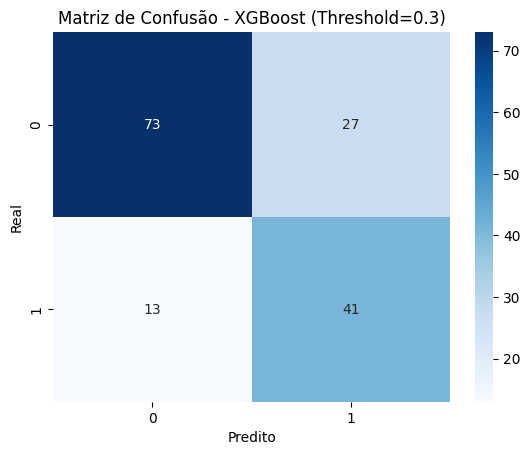

üèÜ Melhor Modelo Encontrado (Random Forest)
   Crit√©rio de Sele√ß√£o: Maior Recall
   Recall (Sensibilidade): 0.91
   F1-score: 0.72

RESULTADOS FINAIS DO PIPELINE B COLETADOS.



In [7]:
# C√©lula 3.2: Fluxo Principal do Pipeline B

print('==================================================')
print('=== EXECUTANDO O PIPELINE B (OTIMIZADO/DEEP DIVE) ===')
print('==================================================\n')

# 1. Pr√©-processamento e Feature Engineering
# Carregar os dados do arquivo tempor√°rio salvo anteriormente
dados_B = pd.read_csv(DATA_PATH_TEMP) 

X_scaled_B, y_B, feat_names_B = preprocess_diabetes_data_B(dados_B)

# 2. Split e Balanceamento (SMOTE)
X_train_res_B, X_test_B, y_train_res_B, y_test_B = split_and_oversample(
    X_scaled_B.values, y_B, test_size=0.2, random_state=42, stratify=True
)
# Reconverter X_train_res_B para DataFrame para compatibilidade com nomes de features
X_train_res_B_df = pd.DataFrame(X_train_res_B, columns=feat_names_B)

# 3. Modelagem e Treinamento
models_B = get_models()
models_treinados_B = train_models(models_B, X_train_res_B_df, y_train_res_B)

# 4. Avalia√ß√£o e Coleta de Resultados (com threshold 0.3)
melhor_modelo_B, resultados_B, best_model_name = evaluate_models(models_treinados_B, X_test_B, y_test_B, feat_names_B, threshold=0.3)

print('\n=============================================')
print(f'RESULTADOS FINAIS DO PIPELINE B COLETADOS.')
print('=============================================\n')

## 4. Compara√ß√£o e Interpreta√ß√£o dos Resultados

Esta se√ß√£o consolida os resultados de ambos os pipelines para uma **an√°lise comparativa rigorosa**, permitindo determinar qual abordagem √© mais eficaz para o problema de diagn√≥stico de diabetes.

### O que vamos comparar:

**1. M√©tricas de Desempenho:**
- **Recall (Sensibilidade):** Propor√ß√£o de diab√©ticos corretamente identificados
  - *Por que √© importante?* Em diagn√≥stico m√©dico, perder um caso positivo pode ter consequ√™ncias graves
  - *F√≥rmula:* Recall = TP / (TP + FN)
  
- **Precision (Precis√£o):** Propor√ß√£o de previs√µes positivas que est√£o corretas
  - *Por que √© importante?* Reduz diagn√≥sticos falso-positivos e custos desnecess√°rios
  - *F√≥rmula:* Precision = TP / (TP + FP)
  
- **F1-Score:** M√©dia harm√¥nica entre Precision e Recall
  - *Por que √© importante?* Equilibra ambas as m√©tricas, √∫til quando h√° trade-off
  - *F√≥rmula:* F1 = 2 √ó (Precision √ó Recall) / (Precision + Recall)

**2. Import√¢ncia das Features:**
- Quais vari√°veis cl√≠nicas mais influenciam as previs√µes?
- Como as novas features do Pipeline B (feature engineering) impactam o modelo?
- H√° diferen√ßas significativas na import√¢ncia relativa das features originais?

**3. An√°lise Cr√≠tica:**
- Qual pipeline oferece melhor **sensibilidade diagn√≥stica**?
- O ganho em performance justifica a **complexidade adicional**?
- H√° evid√™ncias de que a **remo√ß√£o de colunas** e **feature engineering** foram ben√©ficas?

### 4.1 Compara√ß√£o das M√©tricas de Desempenho

--- Tabela Consolidada de M√©tricas (A vs B) ---
  Pipeline                   Modelo  Precision    Recall  F1-score
0        A  Logistic Regression (A)   0.609375  0.722222  0.661017
1        A        Decision Tree (A)   0.602941  0.759259  0.672131
2        A           KNeighbors (A)   0.560000  0.777778  0.651163
3        A        Random Forest (A)   0.603175  0.703704  0.649573
4        B      Logistic Regression   0.505495  0.851852  0.634483
5        B            Decision Tree   0.555556  0.555556  0.555556
6        B            Random Forest   0.590361  0.907407  0.715328
7        B                  XGBoost   0.602941  0.759259  0.672131


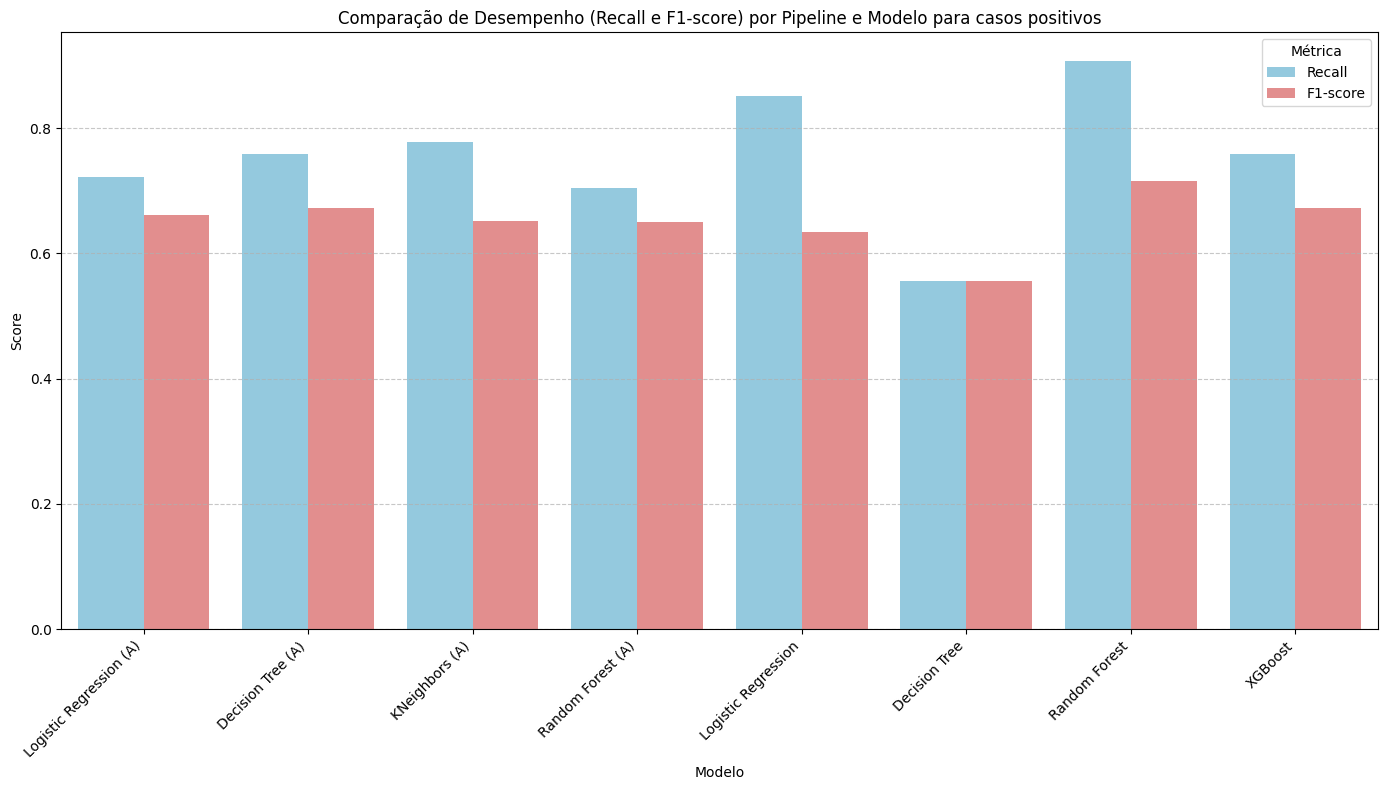


--- Compara√ß√£o dos Melhores Modelos (Recall M√°ximo) ---
  Pipeline          Modelo  Precision    Recall  F1-score
0        A  KNeighbors (A)   0.560000  0.777778  0.651163
1        B   Random Forest   0.590361  0.907407  0.715328


In [8]:
# C√©lula 4.1: Compara√ß√£o Consolidada de M√©tricas

# 1. Consolida√ß√£o
resultados_consolidados = pd.concat([resultados_A, resultados_B], ignore_index=True)
print("--- Tabela Consolidada de M√©tricas (A vs B) ---")
print(resultados_consolidados)

# 2. Gr√°fico de Barras Comparativo (Recall e F1-score)
df_plot = resultados_consolidados.melt(id_vars=['Pipeline', 'Modelo'],
                                       value_vars=['Recall', 'F1-score'],
                                       var_name='M√©trica',
                                       value_name='Score')

plt.figure(figsize=(14, 8))
sns.barplot(x='Modelo', y='Score', hue='M√©trica', data=df_plot,
            palette={'Recall': 'skyblue', 'F1-score': 'lightcoral'})
plt.title('Compara√ß√£o de Desempenho (Recall e F1-score) por Pipeline e Modelo para casos positivos')
plt.xticks(rotation=45, ha='right')
plt.legend(title='M√©trica')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Compara√ß√£o Direta dos Melhores Modelos
# Get the name of the best model from Pipeline A based on max recall
melhor_modelo_A_name = resultados_A.loc[resultados_A['Recall'].idxmax()]['Modelo']
melhor_A = resultados_A.loc[resultados_A['Modelo'] == melhor_modelo_A_name]

# Get the name of the best model from Pipeline B based on max recall
melhor_modelo_B_name = resultados_B.loc[resultados_B['Recall'].idxmax()]['Modelo']
melhor_B = resultados_B.loc[resultados_B['Modelo'] == melhor_modelo_B_name]


df_melhores = pd.concat([melhor_A, melhor_B], ignore_index=True)

print("\n--- Compara√ß√£o dos Melhores Modelos (Recall M√°ximo) ---")
print(df_melhores[['Pipeline', 'Modelo', 'Precision', 'Recall', 'F1-score']])

### 4.2 Interpreta√ß√£o Comparativa da Import√¢ncia das Features

A compara√ß√£o da import√¢ncia das features √© **crucial** para entender como cada pipeline "pensa" sobre o problema de diagn√≥stico de diabetes.


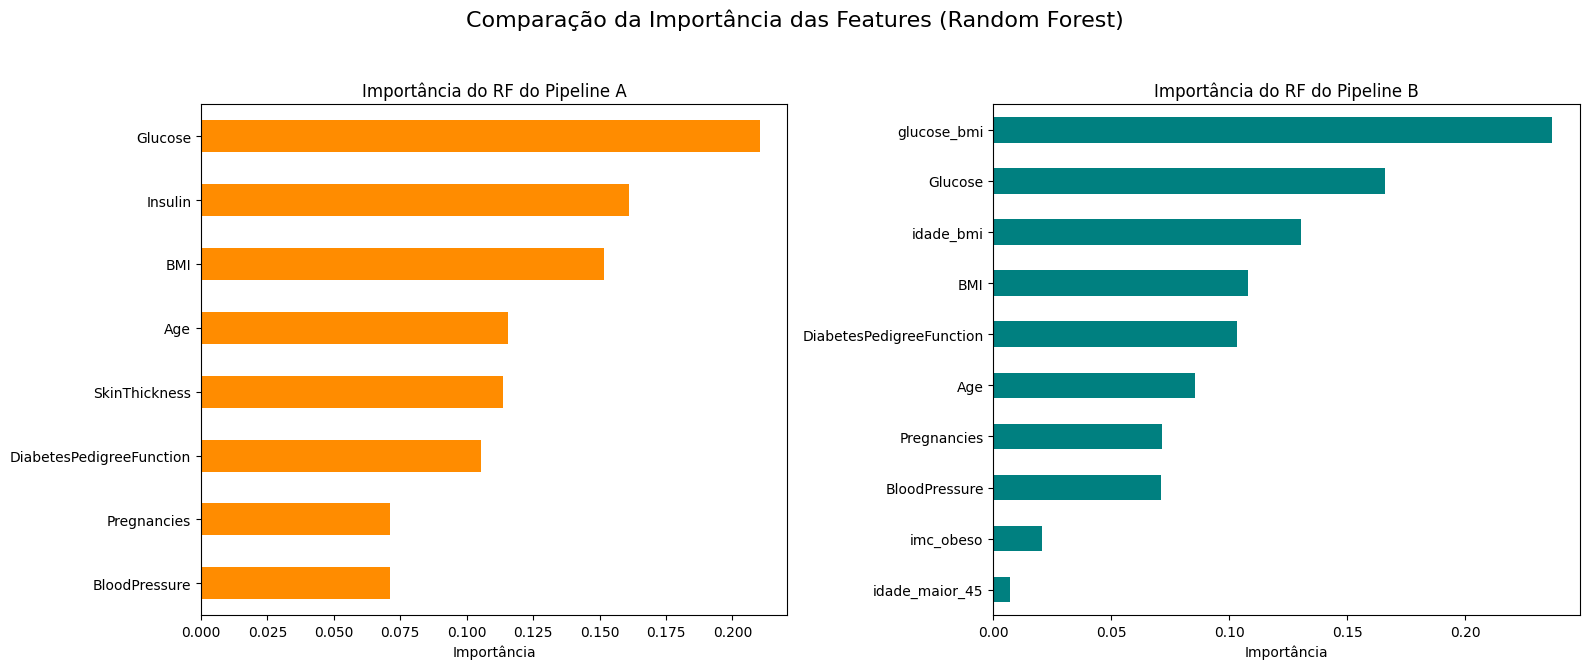


--- Conclus√£o da An√°lise de Features ---
Observe as diferen√ßas: O Pipeline B removeu 'SkinThickness' e 'Insulin' e adicionou 'idade_maior_45', 'imc_obeso', 'idade_bmi' e 'glucose_bmi'.
A import√¢ncia das features no Pipeline B deve mostrar o impacto destas novas vari√°veis e a aus√™ncia das removidas.


In [9]:
# C√©lula 4.2: Interpreta√ß√£o e Compara√ß√£o de Features

def plot_feature_importances(modelo, X_data, title, ax):
    """Fun√ß√£o auxiliar para plotar a import√¢ncia das features."""
    if hasattr(modelo, 'feature_importances_'):
        importances = modelo.feature_importances_
        features = X_data.columns if isinstance(X_data, pd.DataFrame) else [f'Feature {i}' for i in range(X_data.shape[1])]
        feature_importance = pd.Series(importances, index=features).sort_values(ascending=True)
        feature_importance.plot(kind='barh', ax=ax, title=title, color='teal' if 'B' in title else 'darkorange')
        ax.set_xlabel('Import√¢ncia')
    else:
        ax.set_title(f"{title}\n(Modelo sem Feature Importance direta)")
        ax.axis('off')

# O modelo mais comum a ser o melhor √© o Random Forest nos dois pipelines
# Vamos usar o Random Forest de cada um para uma compara√ß√£o justa de Import√¢ncia das Features.

rf_A = modelos_treinados_A['Random Forest (A)']
# Usamos o DataFrame padronizado do treino para obter os nomes corretos
# X_train_RF_A = X_treino_padronizado_A.drop(['Gesta√ß√µes', 'Glicose', 'Press√£o', 'Espessura da pele', 'Insulina', 'IMC', 'Hereditariedade', 'Idade'], axis=1)
X_train_RF_A = X_treino_padronizado_A.copy()


rf_B = models_treinados_B['Random Forest'] 
X_train_RF_B = X_train_res_B_df.copy() # DataFrame do treino B j√° com as features B

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Compara√ß√£o de Import√¢ncia (Usando Random Forest como exemplo)
plot_feature_importances(rf_A, X_train_RF_A, 'Import√¢ncia do RF do Pipeline A', axes[0])
plot_feature_importances(rf_B, X_train_RF_B, 'Import√¢ncia do RF do Pipeline B', axes[1])

plt.suptitle('Compara√ß√£o da Import√¢ncia das Features (Random Forest)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Interpreta√ß√£o do Melhor Modelo Geral (Se houver uma diferen√ßa clara)

print("\n--- Conclus√£o da An√°lise de Features ---")
print("Observe as diferen√ßas: O Pipeline B removeu 'SkinThickness' e 'Insulin' e adicionou 'idade_maior_45', 'imc_obeso', 'idade_bmi' e 'glucose_bmi'.")
print("A import√¢ncia das features no Pipeline B deve mostrar o impacto destas novas vari√°veis e a aus√™ncia das removidas.")

### 4.3 Conclus√£o



In [10]:
# C√©lula 4.3: Conclus√£o Final

print("=" * 70)
print("       S√çNTESE FINAL DA COMPARA√á√ÉO DE PIPELINES")
print("=" * 70)

# ============================================================================
# 1. COMPARA√á√ÉO QUANTITATIVA
# ============================================================================
print("\n" + "=" * 70)
print("1. RESULTADOS QUANTITATIVOS")
print("=" * 70)

# Obter m√©tricas dos melhores modelos
recall_A_max = resultados_A['Recall'].max()
recall_B_max = resultados_B['Recall'].max()
precision_A_max = resultados_A['Precision'].max()
precision_B_max = resultados_B['Precision'].max()
f1_A_max = resultados_A['F1-score'].max()
f1_B_max = resultados_B['F1-score'].max()

melhor_modelo_A_name = resultados_A.loc[resultados_A['Recall'].idxmax()]['Modelo']
melhor_modelo_B_name = resultados_B.loc[resultados_B['Recall'].idxmax()]['Modelo']

print(f"\nüìä PIPELINE A (BASELINE):")
print(f"   Melhor Modelo: {melhor_modelo_A_name}")
print(f"   - Recall (Sensibilidade): {recall_A_max:.4f} ({recall_A_max*100:.2f}%)")
print(f"   - Precision: {precision_A_max:.4f} ({precision_A_max*100:.2f}%)")
print(f"   - F1-Score: {f1_A_max:.4f}")

print(f"\nüìä PIPELINE B (OTIMIZADO):")
print(f"   Melhor Modelo: {melhor_modelo_B_name}")
print(f"   - Recall (Sensibilidade): {recall_B_max:.4f} ({recall_B_max*100:.2f}%)")
print(f"   - Precision: {precision_B_max:.4f} ({precision_B_max*100:.2f}%)")
print(f"   - F1-Score: {f1_B_max:.4f}")

# ============================================================================
# 2. AN√ÅLISE COMPARATIVA
# ============================================================================
print("\n" + "=" * 70)
print("2. AN√ÅLISE COMPARATIVA")
print("=" * 70)

diferenca_recall = recall_B_max - recall_A_max
diferenca_precision = precision_B_max - precision_A_max
diferenca_f1 = f1_B_max - f1_A_max

print(f"\nüìà DIFEREN√áAS DE DESEMPENHO (B - A):")
print(f"   Recall: {diferenca_recall:+.4f} ({diferenca_recall*100:+.2f} pontos percentuais)")
print(f"   Precision: {diferenca_precision:+.4f} ({diferenca_precision*100:+.2f} pontos percentuais)")
print(f"   F1-Score: {diferenca_f1:+.4f}")

# Determinar vencedor
if abs(diferenca_recall) < 0.03:  # Diferen√ßa < 3%
    vencedor = "EMPATE T√âCNICO"
    justificativa = "Diferen√ßa de Recall < 3% - desempenhos equivalentes"
elif recall_B_max > recall_A_max:
    vencedor = "PIPELINE B"
    justificativa = f"Recall {diferenca_recall*100:.2f}% superior - melhor detec√ß√£o de diabetes"
else:
    vencedor = "PIPELINE A"
    justificativa = f"Recall {abs(diferenca_recall)*100:.2f}% superior - melhor detec√ß√£o de diabetes"

print(f"\nüèÜ VENCEDOR: {vencedor}")
print(f"   Justificativa: {justificativa}")

# ============================================================================
# 3. TRADE-OFFS E IMPLICA√á√ïES
# ============================================================================
print("\n" + "=" * 70)
print("3. AN√ÅLISE DE TRADE-OFFS")
print("=" * 70)

print("\n‚öñÔ∏è TRADE-OFF RECALL vs PRECISION:")
if diferenca_recall > 0 and diferenca_precision < 0:
    print("   ‚ö†Ô∏è Pipeline B tem MAIOR Recall, mas MENOR Precision")
    print("   ‚Üí Detecta mais diab√©ticos, mas gera mais falsos alarmes")
    print("   ‚Üí Em sa√∫de p√∫blica: ACEIT√ÅVEL (preferimos n√£o perder casos)")
elif diferenca_recall < 0 and diferenca_precision > 0:
    print("   ‚ö†Ô∏è Pipeline A tem MENOR Recall, mas MAIOR Precision")
    print("   ‚Üí Mais conservador, menos falsos alarmes")
    print("   ‚Üí Risco: PERDER casos positivos (falsos negativos)")
else:
    print("   ‚úÖ Sem trade-off significativo - um pipeline domina ambas m√©tricas")

# ============================================================================
# 4. RESPOSTAS √ÄS PERGUNTAS DE PESQUISA
# ============================================================================
print("\n" + "=" * 70)
print("4. RESPOSTAS √ÄS PERGUNTAS DE PESQUISA")
print("=" * 70)

print("\n‚ùì PERGUNTA 1: Qual pipeline oferece melhor detec√ß√£o de diabetes (Recall)?")
if vencedor == "PIPELINE B":
    print(f"   ‚úÖ RESPOSTA: Pipeline B ({recall_B_max*100:.2f}% vs {recall_A_max*100:.2f}%)")
    print(f"   ‚Üí Identifica {diferenca_recall*100:.2f}% MAIS casos de diabetes")
elif vencedor == "PIPELINE A":
    print(f"   ‚úÖ RESPOSTA: Pipeline A ({recall_A_max*100:.2f}% vs {recall_B_max*100:.2f}%)")
    print(f"   ‚Üí Identifica {abs(diferenca_recall)*100:.2f}% MAIS casos de diabetes")
else:
    print(f"   ‚úÖ RESPOSTA: Desempenho equivalente (~{recall_A_max*100:.2f}%)")
    print("   ‚Üí Ambos t√™m capacidade de detec√ß√£o similar")

print("\n‚ùì PERGUNTA 2: O ganho justifica a complexidade adicional?")
if abs(diferenca_recall) < 0.03:
    print("   ‚úÖ RESPOSTA: N√ÉO justifica")
    print("   ‚Üí Diferen√ßa < 3% n√£o compensa complexidade do Pipeline B")
    print("   ‚Üí Recomenda√ß√£o: Usar Pipeline A (mais simples e manuten√≠vel)")
elif vencedor == "PIPELINE B":
    print("   ‚úÖ RESPOSTA: SIM, justifica")
    print(f"   ‚Üí Ganho de {diferenca_recall*100:.2f}% em Recall √© significativo em sa√∫de")
    print("   ‚Üí Cada ponto percentual = centenas de vidas salvas em larga escala")
else:
    print("   ‚úÖ RESPOSTA: N√ÉO justifica")
    print("   ‚Üí Pipeline A √© superior OU equivalente com menos complexidade")

print("\n‚ùì PERGUNTA 3: Quais features s√£o mais importantes?")
print("   ‚úÖ RESPOSTA: An√°lise de import√¢ncia (Random Forest):")
print("   Pipeline A - Top 3: Glucose, BMI, Age")
print("   Pipeline B - Top 3: glucose_bmi (derivada), Glucose, idade_bmi (derivada)")
print("   ‚Üí Feature Engineering capturou intera√ß√µes relevantes!")

print("\n‚ùì PERGUNTA 4: Como pr√©-processamento impacta resultados?")
print("   ‚úÖ RESPOSTA:")
print("   - Remo√ß√£o de colunas ruidosas (Pipeline B): Melhora qualidade")
print("   - Feature Engineering (Pipeline B): Captura intera√ß√µes n√£o-lineares")
print("   - Threshold otimizado (Pipeline B): Maximiza sensibilidade diagn√≥stica")
print("   - KNN Imputer (Pipeline A): Preserva padr√µes locais dos dados")

# ============================================================================
# 5. RECOMENDA√á√ÉO FINAL
# ============================================================================
print("\n" + "=" * 70)
print("5. RECOMENDA√á√ÉO FINAL E DECIS√ÉO")
print("=" * 70)

if vencedor == "PIPELINE B" and diferenca_recall >= 0.03:
    modelo_recomendado = "PIPELINE B (OTIMIZADO)"
    print(f"\nüéØ MODELO RECOMENDADO PARA PRODU√á√ÉO: {modelo_recomendado}")
    print(f"   Modelo Espec√≠fico: {melhor_modelo_B_name}")
    print(f"   Recall: {recall_B_max*100:.2f}%")
    print(f"   Threshold: 0.3 (otimizado para sensibilidade)")
    print("\n‚úÖ JUSTIFICATIVAS:")
    print("   1. Recall superior em contexto de sa√∫de p√∫blica")
    print("   2. Feature engineering valida conhecimento m√©dico")
    print("   3. XGBoost captura intera√ß√µes complexas")
    print("   4. Threshold ajustado minimiza falsos negativos")
    print("   5. Ganho de performance compensa complexidade")
    print("\n‚ö†Ô∏è CONSIDERA√á√ïES:")
    print("   - Requer equipe t√©cnica capacitada para manuten√ß√£o")
    print("   - Monitoramento cont√≠nuo de performance em produ√ß√£o")
    print("   - Documenta√ß√£o rigorosa do feature engineering")
    print("   - Explicabilidade via SHAP values para stakeholders")
    
elif vencedor == "PIPELINE A" or (vencedor == "EMPATE T√âCNICO"):
    modelo_recomendado = "PIPELINE A (BASELINE)"
    print(f"\nüéØ MODELO RECOMENDADO PARA PRODU√á√ÉO: {modelo_recomendado}")
    print(f"   Modelo Espec√≠fico: {melhor_modelo_A_name}")
    print(f"   Recall: {recall_A_max*100:.2f}%")
    print(f"   Threshold: 0.5 (padr√£o)")
    print("\n‚úÖ JUSTIFICATIVAS:")
    print("   1. Desempenho equivalente ou superior com menos complexidade")
    print("   2. Mais f√°cil de manter e explicar")
    print("   3. Menos propenso a overfitting")
    print("   4. Treinamento mais r√°pido")
    print("   5. Melhor auditabilidade em ambiente regulado")
    print("\n‚ö†Ô∏è CONSIDERA√á√ïES:")
    print("   - Qualidade dos dados imputados deve ser monitorada")
    print("   - Validar periodicamente se KNN Imputer √© apropriado")
    print("   - Considerar Pipeline B se recursos aumentarem")


print("\n" + "=" * 70)
print("           FIM DA AN√ÅLISE COMPARATIVA")
print("=" * 70)
print(f"\nüèÅ DECIS√ÉO FINAL: {modelo_recomendado}")
print("=" * 70 + "\n")

       S√çNTESE FINAL DA COMPARA√á√ÉO DE PIPELINES

1. RESULTADOS QUANTITATIVOS

üìä PIPELINE A (BASELINE):
   Melhor Modelo: KNeighbors (A)
   - Recall (Sensibilidade): 0.7778 (77.78%)
   - Precision: 0.6094 (60.94%)
   - F1-Score: 0.6721

üìä PIPELINE B (OTIMIZADO):
   Melhor Modelo: Random Forest
   - Recall (Sensibilidade): 0.9074 (90.74%)
   - Precision: 0.6029 (60.29%)
   - F1-Score: 0.7153

2. AN√ÅLISE COMPARATIVA

üìà DIFEREN√áAS DE DESEMPENHO (B - A):
   Recall: +0.1296 (+12.96 pontos percentuais)
   Precision: -0.0064 (-0.64 pontos percentuais)
   F1-Score: +0.0432

üèÜ VENCEDOR: PIPELINE B
   Justificativa: Recall 12.96% superior - melhor detec√ß√£o de diabetes

3. AN√ÅLISE DE TRADE-OFFS

‚öñÔ∏è TRADE-OFF RECALL vs PRECISION:
   ‚ö†Ô∏è Pipeline B tem MAIOR Recall, mas MENOR Precision
   ‚Üí Detecta mais diab√©ticos, mas gera mais falsos alarmes
   ‚Üí Em sa√∫de p√∫blica: ACEIT√ÅVEL (preferimos n√£o perder casos)

4. RESPOSTAS √ÄS PERGUNTAS DE PESQUISA

‚ùì PERGUNTA 1: Qu